# Beam Blockage Calculation using DEM

Adapted from https://github.com/wradlib/wradlib-notebooks/blob/master/notebooks/beamblockage/wradlib_beamblock.ipynb

Required:

* the local radar setup (sitecoords, number of rays, number of bins, antenna elevation, beamwidth, and the range resolution);
* a DEM with a adequate resolution.

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

# Setup radar specs

Here the Subic (Philippines) radar is used. Note that the specifications are not valid between June 16, 2015 and May 25, 2016 as the radar was experiencing technical issues and was operating under a different setting.

In [2]:
# setup radar specs (Subic Radar)
radarshortname = 'sub'
sitecoords = (120.363746, 14.822138, 532)   # site coordinates
nrays = 360                                 # number of rays
nbins = 240                                 # number of range bins
el = 0.5                                    # vertical antenna pointing angle (deg)
bw = 1.0                                    # half power beam width (deg)
range_res = 500.                            # range resolution (meters)

Create the range, azimuth, and beam radius arrays.

In [3]:
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

We use

* [wradlib.georef.sweep_centroids](http://docs.wradlib.org/en/latest/generated/wradlib.georef.polar.sweep_centroids.html) and
* [wradlib.georef.spherical_to_proj](http://docs.wradlib.org/en/latest/generated/wradlib.georef.polar.spherical_to_proj.html)

to calculate the spherical coordinates of the bin centroids and their longitude, latitude and altitude.

In [4]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
coords = wrl.georef.spherical_to_proj(coord[..., 0], 
                                      np.degrees(coord[..., 1]),
                                      coord[..., 2], sitecoords)
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

In [5]:
polcoords = coords[..., :2]

In [6]:
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print("Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f" % 
      (lat.max(), lon.min(), lon.max(), lat.min()))

Radar bounding box:
	15.90
119.25             121.48
	13.74


# Preprocessing the digitial elevation model

* Read the DEM from a geotiff file;
* clip the region inside the bounding box;
* map the DEM values to the polar grid points.

The DEM raster data is opened via [wradlib.io.open_raster](http://docs.wradlib.org/en/latest/generated/wradlib.io.gdal.open_raster.html) and extracted via [wradlib.georef.extract_raster_dataset](http://docs.wradlib.org/en/latest/generated/wradlib.georef.raster.extract_raster_dataset.html).

In [7]:
rasterfile = '../data/gis/PH_13_15N_119_121E_clip4.tif'
ds = wrl.io.open_raster(rasterfile)
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds, nodata=-32768.)

In [8]:
# Clip the region inside our bounding box 
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]

In [9]:
# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(rastercoords, rastervalues,
                                             polcoords, order=3,
                                             prefilter=False)

# Calculate Beam-Blockage

Now we can finally apply the [wradlib.qual.beam_block_frac](http://docs.wradlib.org/en/latest/generated/wradlib.qual.beam_block_frac.html) function to calculate the PBB.

In [10]:
PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
PBB = np.ma.masked_invalid(PBB)
print(PBB.shape)

(360, 240)


So far, we calculated the fraction of beam blockage for each bin.

But we need to into account that the radar signal travels along a beam. Cumulative beam blockage (CBB) in one bin along a beam will always be at least as high as the maximum PBB of the preceeding bins (see [wradlib.qual.cum_beam_block_frac](http://docs.wradlib.org/en/latest/generated/wradlib.qual.cum_beam_block_frac.html))

In [11]:
CBB = wrl.qual.cum_beam_block_frac(PBB)
print(CBB.shape)

(360, 240)


# Visualize Beam Blockage

In [12]:
# get radar bounding box lonlat
lonmin = np.min(lon)
lonmax = np.max(lon)
latmin = np.min(lat)
latmax = np.max(lat)
rlimits = [lonmin, latmin, lonmax, latmax]
print("radar bounding box:", rlimits)

radar bounding box: [119.25155516652961, 13.740171940004066, 121.47593683347029, 15.904002149836867]


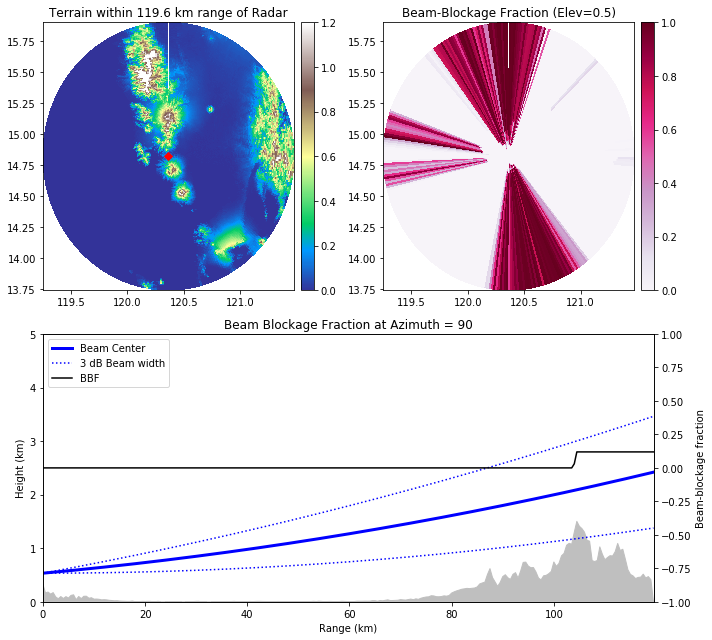

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plotting the stuff
fig = pl.figure(figsize=(10, 9))

# create subplots
ax1 = pl.subplot2grid((2, 2), (0, 0))
ax2 = pl.subplot2grid((2, 2), (0, 1))
ax3 = pl.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 90

# plot terrain
dem = ax1.pcolormesh(lon, lat, polarvalues / 1000., cmap=mpl.cm.terrain,
                     vmin=0.0, vmax=1.2)
ax1.plot(sitecoords[0], sitecoords[1], 'rD')
ax1.set_title(
    'Terrain within {0} km range of Radar'.format(np.max(r / 1000.) + 0.1))
# colorbar
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.1)
fig.colorbar(dem, cax=cax1)
# limits

ax1.set_xlim(lonmin, lonmax)
ax1.set_ylim(latmin, latmax)
ax1.set_aspect('auto')

# plot CBB on ax2
cbb = ax2.pcolormesh(lon, lat, CBB, cmap=mpl.cm.PuRd, vmin=0, vmax=1)
ax2.set_title('Beam-Blockage Fraction (Elev=%s)'%el)
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes("right", size="5%", pad=0.1)
# colorbar
fig.colorbar(cbb, cax=cax2)
# limits
ax2.set_xlim(lonmin, lonmax)
ax2.set_ylim(latmin, latmax)
ax2.set_aspect('auto')

# plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., alt[angle, :] / 1000., '-b',
               linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius) / 1000., ':b',
                 linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (alt[angle, :] - beamradius) / 1000., ':b')
ax3.fill_between(r / 1000., 0.,
                 polarvalues[angle, :] / 1000.,
                 color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 5)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Height (km)')
ax3.set_title('Beam Blockage Fraction at Azimuth = %s'%angle)

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(-1., 1.)
axb.set_xlim(0., np.max(r / 1000.) + 0.1)

legend = ax3.legend((bc, b3db, bbf), ('Beam Center', '3 dB Beam width', 'BBF'),
                    loc='upper left', fontsize=10)

pl.tight_layout()

In [15]:
# save cumulative beam blockage to file
str_el = str(el).replace('.','')
wrl.io.to_hdf5('../output/bbfmap/' + radarshortname + '_bbf_{0}.hdf5'.format(str_el),CBB)

# Convert to Quality Map

The beam blockage map is converted to a quality map following the transformation function suggested by [Zhang et al.(2011)](https://www.nssl.noaa.gov/projects/q2/tutorial/images/mosaic/WRaH_Proceedings_Zhang-et-al_v3.pdf):

\begin{equation}
Q_{BBF} =
\begin{cases}
1 & BBF \leq 0.1\\
1 - \frac{BBF - 0.1}{0.4} & 0.1 < BBF \leq 0.5\\
0 & BBF > 0.5
\end{cases}
\end{equation}

In [21]:
RQI = np.empty_like(CBB)*np.nan

In [22]:
# apply Zhang2011

RQI[CBB<=0.1] = 1
RQI[np.where((CBB>0.1) & (CBB<=0.5))] = 1 - (CBB[np.where((CBB>0.1) & (CBB<=0.5))]-0.1)/0.4
RQI[CBB>0.5] = 0

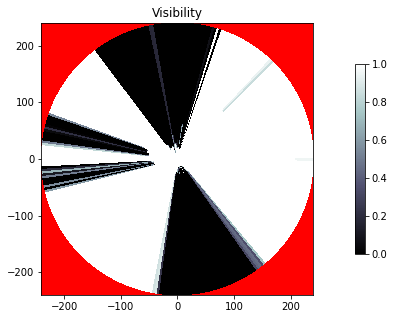

In [19]:
fig, ax1 = pl.subplots(1,1, figsize=(15,5))

ax1,pm = wrl.vis.plot_ppi(np.ma.masked_invalid(RQI),cmap=pl.cm.bone, ax=ax1)
cbar = pl.colorbar(pm,ax=ax1, shrink=0.7)
ax1.set_title('Visibility')
ax1.set_axis_bgcolor('red')

In [20]:
wrl.io.to_hdf5('../output/bbfmap/SUB_qual_ee0_BBF.hdf5',RQI)